<a href="https://colab.research.google.com/github/GianluigiSilvestri/asvi/blob/master/asvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Structured Variational Inference

In this notebook, I will explain the Automatic Structured Variational Inference (ASVI) method [[1]](#asvi), providing a comparison with the widely used mean field approximation (MF) (as proposed in [[2]](#advi)).

I will start with an introduction of the difficulties arising when using probabilistic programming in practice, followed by a description of MF and its limitations. I will then move to the description of ASVI and its advantages.

All the steps will be followed by a Pytorch implementation, with a comparison of the performances of MF and ASVI on the problems of Brownian motion smoothing and Brownian motion bridge.

**NOTE**: The description and code provided here are meant to be simple and intuitive, to help understand the main concepts. The more detailed and rigorous explanation can be found in the ASVI paper [[1]](#asvi), and an official TensorFlow Probability implementation is available [here](https://www.tensorflow.org/probability/api_docs/python/tfp/experimental/vi/build_asvi_surrogate_posterior). 

## 1 - Introduction

With the recent developments of Variational Inference and the availability of libraries which allow to use automatic differentiation (such as TensorFlow and PyTorch), it is now possible to easily implement gradient based automatic differentiation stochastic
variational inference and use it on big datasets with high-dimensional models.

However, it is still required to choose an appropriate variational distribution.

Given a multidimensional prior distribution $p(z_1,...,z_M)$ with a set of latent variables $z_1,...,z_M$, it is complicated to design a multivariate variational distribution.
The most common approach, and perhaps the easiest to use, is the so-called mean-field approximation: you simply assume that all the latent variables are statistically independent, rewriting the multivariate approximate posterior $q(z_1,...,z_M)$ as: 
$$q(z_1,...,z_M) = \prod_m^Mq_m(z_m)$$
MF works well only when the latent variables are not correlated (which is not always the case), otherwise can underestimate the true variance.

Several approaches have been proposed to overcome the limitations of MF, while trying to remain as simple and as efficient. Some of these approaches are, for example, [[3]](#cvi), [[4]](#ssvi) and [[5]](#hvi), which despite being able to capture dependencies between latent variables, they require additional design, longer computation, and are limited to specific variational families.

A different solution is proposed in ASVI, where a structured variational faimily is authomatically constructed from the prior. Therefore, ASVI requires only to specify the likelihood and prior distributions, and does not require specific gradient estimators or  ad-hoc variational lower bounds.

## 2 - ASVI and the convex-update variational families

The main innovation of ASVI is the introduction of convex-update variational families. Before explaining the details, let's first quickly review the concept of conjugate prior.

### 2.1 - Closed-form update with conjugate priors

When the likelihood function is multiplied by the prior, if the prior distribution is conjugate to the likelihood, then the posterior distribution will have the same distribution as the prior. If the likelihood belongs to the exponential family, and the prior is conjugate, then we can compute the expectation parameters of the posterior distribution with a convex combination of the prior parameters and the maximum likelihood estimators: $$\mathbf{\bar{\mu}} = \mathbf{\lambda}\odot\mathbf{\bar{\mu_0}}+(1-\mathbf{\lambda})\odot\mathbf{\mu_{ML}}$$ with $\mathbf{\bar{\mu_0}}$ the prior expectations, $\mathbf{\lambda}$ a vector of convex combination coefficients, $\odot$ the element-wise product and $\mathbf{\mu_{ML}}$ the maximum likelihood estimators.

An example is the mean update for a monodimensional Gaussian likelihood with precision $\tau$ over $N$ independely sampled datapoints $y_n$ and a monodimensional Gaussian prior over the mean with mean $\mu_0$ and precision $\tau_0$. The posterior mean can be computed with the following update: $$\mu = \frac{\tau_0}{\tau_0 + N\tau}\mu_0 + \frac{N\tau}{\tau_0+N\tau}\left(\frac{1}{N}\sum_{n=1}^Ny_n\right),$$ with $y_n$ the data points.
The posterior mean becomes an interpolation between the maximum likelihood mean and the prior mean. If $N$ is small, the influence of the prior on the posterior will be big, since we cannot trust the data too much, while if $N$ is big then the data is a reliable source of information, and the prior will have almost no influence.

### 2.2 - Convex-update variational families

The convex-update variatiomal families are inspired by the conjugate parameter update in the exponential family, and are applicable also to models where likelihood and priors are not in the exponential family and where the prior is not conjugate (otherwise, we would not need it).

Let's consider a prbabilistic model with a prior $p(x\mid\mathbf{\theta})$ parametrized by the vector of parameters $\mathbf{\theta}$. Then, the convex-update posterior is defined as: $$q(x; \mathbf{\lambda},\mathbf{\alpha})=p(x\mid\mathbf{\lambda}\odot\mathbf{\theta}+(1-\mathbf{\lambda})\odot\mathbf{\alpha}),$$

where $\mathbf{\theta}$ is the vector of (fixed) parameters of the prior, $\mathbf{\alpha}$ hs the same dimensionality of $\mathbf{\theta}$ and is a vector of learnable parameters which will have to mimic the behavior of the maximum likelihood estimators in the cojugate update, and $\mathbf{\lambda}$ is a vector of learnable parameters which will be used as the coefficients for the convex combination update (therefore restricted to be between 0 and 1).

### 2.3 ASVI

With the pseudo-conjugate variational family, using ASVI is as simple as using the Mean Field approach, but instead of assuming independence between latent variables, ASVI will authomatically include the structure of the prior, without additional design choice or ad-hoc computation of the gradients and variational lower bound. Moreover, ASVI only doubles the number of parameters required: if MF needs $P$ parameters (dimensionality if $\mathbf{\theta}$), then ASVI will require $2P$ parameters. The rest of the algorithm is exactly like MF.

In the extreme cases, ASVI can recover the exact prior by setting all the $\mathbf{\lambda}$ to 1, or be the same as MF by setting all the $\mathbf{\lambda}$ to 0.

Using the structure of the prior for the variational approximation is a great improvement over standard MF, since it does not add any complications and keeps the number of parameters low. However, it comes with the limitation that the posterior cannot capture dependencies that are not included in the prior.

## 3 - A practical example

To show the advantages of ASVI, we will now compare its performances with MF on two simple problems: the Brownian smoothing and the Brownian bridge. We will start, as usual, by importing the necessary python libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.distributions import Normal
import torch.nn.functional as F
from time import sleep

plt.style.use('seaborn')

Plot function

In [2]:
def plot_results(model, data, truth, title=None, bridge=None):
    T = len(truth)
    samples = model.sample(100)
    mus = samples.mean(0).detach().numpy()
    std = samples.std(0).detach().numpy()

    # plot samples from the posterior
    for sample in samples:
        plt.plot(sample.detach().numpy(), linewidth=0.3)
        
    plt.plot(mus, label='posterior', c='blue')
    plt.fill_between(np.arange(T), mus - std, mus + std, alpha=.4)
    if bridge:
        plt.plot(range(bridge), data[0], label='observed', c='r')
        plt.plot(range(T-bridge,T,1), data[1], c='r')
    else:
        plt.plot(data, label='observed', c='red')
    plt.plot(bm.x, label='true', c='green')
    plt.legend()
    if title:
        plt.title(title)

Training function

In [3]:
def train_model(model, data):
    '''
    requires a model, either ASVI or MF as defined above,
    and the noisy time series
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    losses = np.array([])
    with tqdm(range(EPOCHS), unit="epochs") as tepoch:

        for epoch in tepoch:

            optimizer.zero_grad()

            # sample latent variables
            z = model.sample()

            # minimize negative elbo
            loss = -model.elbo(z, data).mean()

            loss.backward()
            optimizer.step()
            
            losses = np.append(losses,loss.item())
            
            # display mean loss for last 50 epochs every 50 epochs
            if (epoch+1)%50==0:
                tepoch.set_postfix(loss=losses[-50:].mean())
                
    return model

### 3.1 - Brownian motion

In this problem, we will observe a process over $T$ time steps, which will form a time series $y_0,...,y_{T-1}$ denoted as $\mathbf{y}$. The probability distribution of $y_0$ is a Gaussian distribution centered in 0 and with standard deviation $\sigma$: $$y_0 \sim \mathcal{N}(0, \sigma^2).$$
For the remaining time steps, the mean is centered on the point sampled at the previous step, and the standard deviation remains the same: $$y_t \sim \mathcal{N}(y_{t-1}, \sigma^2).$$ The probabilitiy of the whole series can be written as: $$p(\mathbf{y})=p(y_0)\prod_{t=1}^{T-1}p(y_t\mid y_{t-1}).$$

It is easy to see how each time step is conditioned on the previous one, which makes the means of consecutive time steps correlated.

In the smoothing problem, we will not have access to the real time series, but rather to noisy observations. Therefore, the actual series that we will use is obtained by sampling from each point with a small standard deviation. The goal is to recover the original time series given the noisy observation.

In the bridge problem, similarly to the smoothing case, we will have access to the noisy obesrvation, but only to the initial and final parts. The goal is, again, to recover the original time series (but this time, we have no clue what happened in the intermediate time steps).

The class used to generate the data is shown below.

_**Note 1:**_ there is a parameter $dt$, which represent the fact that this process is a discretization of a continuous-time process, using the Euler-Maruyama method.

_**Note 2:**_ When you see in text something like $x \sim \mathcal{N}(a,b)$, $b$ refers to the variance $\sigma^2$ of the Gaussian distribution. However, in most of the python libraries (also in PyTorch), if you sample from a normal distribution `torch.normal(a, b)`, then b refers to the standard deviation $\sigma$. Make sure to keep an eye on this and to do the right converisons from papers to code.


In [4]:
class BrownianMotion():
    '''
    Class to generate a Brownian motion.
    self.x will contain the ground truth,
    while self.obs will be the noisy observation
    '''
    def __init__(self, T=40, dt=0.01):
        '''
        T is the total lenght of the time series
        dt is the time step approximation
        '''
        self.T = T
        self.dt = dt
        self.x = self._gen()
        self.obs = self._gen_noisy()

    def _gen(self):
        '''
        generates ground truth time series of lenght 40, with std = 1
        in the discratization, the std has to be multiplied by sqrt(dt)
        '''
        x = [0]
        for t in range(self.T - 1):
            x.append(x[-1] + np.sqrt(self.dt) * np.random.normal(0, 1))
        return x

    def _gen_noisy(self):
        '''
        generates noisy observations, centered on ground truth and with std = 0.15
        '''
        x = []
        for i in self.x:
            x.append(i + np.random.normal(0, 0.15))
        return x

    def get_obs(self):
        '''
        returns the noisy time series, for smoothing
        '''
        return torch.tensor(self.obs)

    def get_obs_bridge(self, t=10):
        '''
        returns only the first and last t steps of the noisy time series,
        for bridge
        '''
        return torch.tensor(self.obs[:t]), torch.tensor(self.obs[-t:])

### 3.2 - Mean Field and ASVI models

It's time for the implementation of the models! Let's start from the Mean Field, since ASVI can be obtained as a simple extension.

Our model has a latent variable $z_t$ for each time step. We will assume that the standard deviation is known and will try to estimate a Gaussian posterior for the mean parameter, parametrized by $\mathbf{\phi}$, which in our case consists of $(\phi_{\mu,t}, \phi_{\sigma,t}),\; \forall t \in [0,T-1]$. We can sample from the variational parameters in a differentiable way by using the  reparametrization trick, which is already implemented in PyTorch with the method `rsample()`. For Gaussian distribution, it can be formalized as $$\mathcal{f}_{\phi,t}(\epsilon)=SP(\phi_{\sigma,t})\epsilon+\phi_{\mu,t},\;\epsilon\sim\mathcal{N}(0,1),$$

where $SP(\cdot)$ is the softplus function, which allows us to optimize $\phi_\sigma$ on all the real values (note that the standard deviation has to be $>0$.

The likelihood can be defined as: $$\prod_{t=0}^{T-1}p(x_t\mid z_t),$$ where $x_t$ are the noisy observation with standard devation $\sigma_{n}=0.15$, and $p(x_t\mid z_t) = N(x_t\mid z_t, \sigma_n^2)$.

Given the nature of the problem, it is reaonable to use as prior for each time step a Gaussian distribution centered on the previous observation in the time series. Therefore, the prior at each time step can be defined as: $$p(z_t\mid z_{t-1})=\mathcal{N}(z_{t-1}, \sigma_t),$$ with $\sigma_t=1 * \sqrt{dt} = 0.1$. The total prior can be obtained as product of each prior, using $p(z_0)=\mathcal{N}(z_0\mid 0,0.1)$.

For the posterior, using the mean-field approximation, each latent variable is considered as independent. Therefore, the total posterior is: $$\prod_{t=0}^{T-1}p(z_t\mid\phi)=\prod_{t=0}^{T-1}\mathcal{N}(z_t\mid\phi_{\mu,t}, SP(\phi_{\sigma,t}))$$

In [5]:
class MeanFeald(nn.Module):
    def __init__(self, T, bridge_t=None):
        super(MeanFeald, self).__init__()
        self.T = T
        self.phi = nn.Parameter(torch.tensor(torch.randn(T, 2), requires_grad=True))

        # should be < T/2
        self.b_t = bridge_t # used for bridge problem, first and last t observed

    def sample(self, n=50):
        '''
        sample n series of length T of latent variables
        shape --> n x T
        '''
        return Normal(self.phi[:, 0], F.softplus(self.phi[:, 1])).rsample([n])

    def log_lik(self, z, data):
        '''
        log likelihood function
        '''
        if self.b_t:
            p0 = Normal(z[:,:self.b_t], 0.15).log_prob(data[0])
            p1 = Normal(z[:,-self.b_t:], 0.15).log_prob(data[1])
            ll = torch.cat((p0,p1),1).sum(1)
        else:
            # sum over T (axis 1), return tensor of size n
            ll = Normal(z, 0.15).log_prob(data).sum(1)

        return ll

    def log_prior(self, z):
        
        # at t=0, prior is N(z_0 | 0,0.1)
        lp0 = Normal(0, 0.1).log_prob(z[:,0]).unsqueeze(1)

        # for other t, prior is N(z_t | z_(t-1), 0.1)
        lpn = Normal(z[:,:-1], 0.1).log_prob(z[:,1:])

        # concatenate the two tensors and sum over T (axis 1)
        lp = torch.cat([lp0,lpn],dim=1).sum(1)

        return lp

    def log_q(self, z):
        ''' log probability of approximated posterior'''
        lq = Normal(self.phi[:,0], F.softplus(self.phi[:,1])).log_prob(z).sum(1)
        return lq

    def elbo(self, z, data):
        '''
        elbo function --> likelihood + prior - approximate posterior q
        z: sampled latent variables
        data: noisy observation from time series
        '''
        return self.log_lik(z, data) + self.log_prior(z) - self.log_q(z)

Alright! Now that MF is implemented, we can literally copy-paste the code, change a few things, and have ASVI ready to run!

As mentioned earlier, the convex-update family combines the prior parameters with learnable parameters $\lambda$ and $\alpha$. This will allow us to include our knowledge about the model, i.e. that $z_t$ is correlated to $z_{t-1}$. Therefore, we need to redefine $\mathbf{\phi}$ as: $$\mathbf{\phi}=\mathbf{\lambda}\odot\mathbf{\theta}+(1-\mathbf{\lambda})\odot\mathbf{\alpha},$$ with $\theta$ being the $T$-dimensinal prior tensor, and $\lambda$ and $\alpha$ having the same dimensionality.

The sampling of the latent variables can now be performed as before, but this time sequentially, since the prior at each time step is dependent on the latent variable at the previous time step (which needs to be sampled first!). The posterior computation remains the same, but using the new definition of $\mathbf{\phi}$.

In [6]:
def convex_update(theta, lambd, alpha):
    return theta*torch.sigmoid(lambd) + (1-torch.sigmoid(lambd))*alpha

class ASVI(nn.Module):
    def __init__(self, T, bridge_t=None):
        super(ASVI, self).__init__()
        self.T = T

         # should be < T/2
        self.b_t = bridge_t # used for bridge problem, first and last t observed

        self.lambd = nn.Parameter(torch.tensor(torch.randn(T,2), requires_grad=True))
        self.alpha = nn.Parameter(torch.tensor(torch.randn(T,2), requires_grad=True))

        self.pm0 = torch.tensor([0]) # prior mean at t=0

        # we use log std for the convex update,
        # since we need to guarantee that the update is > 0
        # so we still use softplus afterwards
        self.log_ps = torch.log(torch.tensor([0.1])) # log of prior std, same for all t

    def sample(self, n=50):
        '''
        sample n series of length T of latent variables
        shape --> n x T
        '''

        # compute posterior mean and log_std for t=0 
        mean = convex_update(self.pm0, self.lambd[0,0], self.alpha[0,0])
        std = convex_update(self.log_ps, self.lambd[0,1], self.alpha[0,1])

        # sample latent variable for t=0
        z = [Normal(mean, F.softplus(std)).rsample([n]).unsqueeze(1)]

        # repeat for the remainig time steps
        for t in range(1, self.T):
            
            # here the prior mean is in z[t-1] (last element of the list)
            mean = convex_update(z[-1], self.lambd[t,0], self.alpha[t,0])
            std = convex_update(self.log_ps, self.lambd[t,1], self.alpha[t,1])

            # this time we don't need to specify n 
            # since the tensor has already size (n,)
            z.append(Normal(mean, F.softplus(std)).rsample())

        return torch.cat(z,1).squeeze()

    def log_lik(self, z, data):
        '''
        log likelihood function
        '''
        if self.b_t:
            p0 = Normal(z[:,:self.b_t], 0.15).log_prob(data[0])
            p1 = Normal(z[:,-self.b_t:], 0.15).log_prob(data[1])
            ll = torch.cat((p0,p1),1).sum(1)
        else:
            # sum over T (axis 1), return tensor of size n
            ll = Normal(z, 0.15).log_prob(data).sum(1)

        return ll

    def log_prior(self, z):
        
        # at t=0, prior is N(z_0 | 0,0.1)
        lp0 = Normal(0, 0.1).log_prob(z[:,0]).unsqueeze(1)

        # for other t, prior is N(z_t | z_(t-1), 0.1)
        lpn = Normal(z[:,:-1], 0.1).log_prob(z[:,1:])

        # concatenate the two tensors and sum over T (axis 1)
        lp = torch.cat([lp0,lpn],dim=1).sum(1)

        return lp

    def log_q(self, z):
        ''' log probability of approximated posterior'''

        # the prior mean is [0, z0, z1, .., z_(t-1)]
        prior_mean = self.pm0.repeat(z.shape[0]).unsqueeze(1)
        prior_mean = torch.cat((prior_mean, z), 1)[:,:-1]

        q_mean = convex_update(prior_mean, self.lambd[:,0], self.alpha[:,0])
        q_std = convex_update(self.log_ps, self.lambd[:,1], self.alpha[:,1])
        
        lq = Normal(q_mean, F.softplus(q_std)).log_prob(z).sum(1)
        return lq

    def elbo(self, z, data):
        '''
        elbo function --> likelihood + prior - approximate posterior q
        z: sampled latent variables
        data: noisy observation from time series
        '''
        return self.log_lik(z, data) + self.log_prior(z) - self.log_q(z)

### 3.3 - MF and ASVI for Brownian Smoothing

In [7]:
EPOCHS = 20000
T = 40  # number of time steps
dt = 0.01 
bm = BrownianMotion(T=T, dt=dt)
data = bm.get_obs()
bridge_data = bm.get_obs_bridge()

In [8]:
mf_smoothing = train_model(MeanFeald(T), data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [9]:
asvi_smoothing = train_model(ASVI(T), data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


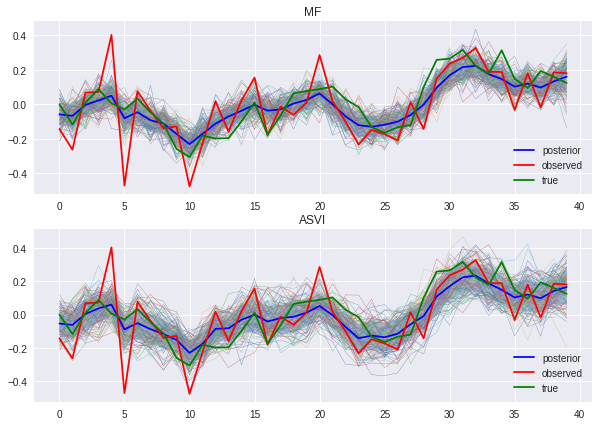

In [15]:
fig = plt.figure(figsize=(10,7))

plt.subplot(2, 1, 1)
plot_results(mf_smoothing, data, bm.x, 'MF')

plt.subplot(2, 1, 2)
plot_results(asvi_smoothing, data, bm.x, 'ASVI')

plt.show()

### 3.4 - MF and ASVI for Brownian Bridge

In [11]:
mf_bridge = train_model(MeanFeald(T=T, bridge_t=10), bridge_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [12]:
asvi_bridge = train_model(ASVI(T=T, bridge_t=10), bridge_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


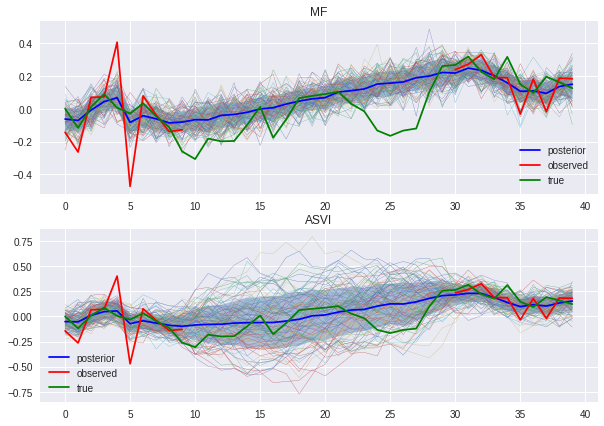

In [14]:
fig = plt.figure(figsize=(10,7))

plt.subplot(2, 1, 1)
plot_results(mf_bridge, bridge_data, bm.x, 'MF', bridge=10)

plt.subplot(2, 1, 2)
plot_results(asvi_bridge, bridge_data, bm.x, 'ASVI', bridge=10)

plt.show()

## 4 - Conclusions


In this notebook, we have seen how to implement both Mean Field variational inference and Automatic Structured Variational Inference. From the results, it is possible to see how MF underestimates the variance of the posterior distribution, which is a known issue. ASVI can easily overcome this with a simple modification to the approximate posterior, by using the convex-update variational family.

The Brownian motion used as example is a simple toy problem which allowed us to focus mostly on the algorithms. However, ASVI is applicable to a wide range of problems, and you can find more details in the paper.

Finally, as the name suggests, ASVI allows to authomatically create structured variational families without adding complexity or requiring any modification, and you only need to define likelihood and prior distributions. In addition, the [official implementation](https://www.tensorflow.org/probability/api_docs/python/tfp/experimental/vi/build_asvi_surrogate_posterior) in TensorFlow Probability makes ASVI ready to be used in industrial applications and easily integrated in production-ready code.

## References

<a name="asvi">[1] Ambrogioni, Luca, Max Hinne, and Marcel van Gerven. "Automatic structured variational inference." arXiv preprint arXiv:2002.00643 (2020).</a>

<a name="advi">[2] Kucukelbir, Alp, et al. "Automatic differentiation variational inference." The Journal of Machine Learning Research 18.1 (2017): 430-474.</a>

<a name="cvi">[3] Tran, Dustin, David M. Blei, and Edoardo M. Airoldi. "Copula variational inference." arXiv preprint arXiv:1506.03159 (2015).</a>

<a name="ssvi">[4] Hoffman, Matthew, and David Blei. "Stochastic structured variational inference." Artificial Intelligence and Statistics. PMLR, 2015.
</a>

<a name="hvi">[5] Ranganath, Rajesh, Dustin Tran, and David Blei. "Hierarchical variational models." International Conference on Machine Learning. PMLR, 2016.

</a>